In [181]:
import time
from datetime import datetime
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import requests
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

---

## Описание задачи:
плашка

плашка

плашка

плашка

плашка

---

## Технический блок.

## Содержание:
### - Парсер
### - Функция проверки стационарности ряда

### В данном блоке представлена функция парсера для сбора данных с сайта westmetall, который в свою очередь собирает данные с Лондонской Биржи Металлов (LME), решение собирать датасет со сторонней площадки обусловлено нижеследующими факторами:
    
    - LME с недавнего времени использует защиту CloudFlare обойти которую не получилось ни с помощью Selenium, ни с помощью sneak-парсеров, ни с помощью Scrapy, были перепробованы разные стратегии, не приведшие к результату.
    
    - Westmetall предоставляет верифицированные исторические данные, доступ к которым непосредственно на LME, закрыт пэйволом. Верификация подтверждается фактом работы с LME и Westmetall на протяжение 5-6 лет на нынешнем месте работы. 
    
    - В принципе я мог взять готовые датасеты из собственных наработок, но в таком случае не представилось бы возможности представить на суд парсер.
    

In [55]:
# Парсер для получения данных с westmetall
def parser(metall_str: str):
    url = f'https://www.westmetall.com/en/markdaten.php?action=table&field=LME_{metall_str}_cash'
        
    response = requests.get(url=url)
    
    # преобразуем ответ в датафрейм
    df_2023 = pd.read_html(response.text)[0]
    df_2022 = pd.read_html(response.text)[1]
    df_2021 = pd.read_html(response.text)[2]
    df_2020 = pd.read_html(response.text)[3]
    df_2019 = pd.read_html(response.text)[4]
    df_2018 = pd.read_html(response.text)[5]
    df_2017 = pd.read_html(response.text)[6]
    df_2016 = pd.read_html(response.text)[7]
    df_2015 = pd.read_html(response.text)[8]
    df_2014 = pd.read_html(response.text)[9]
    df_2013 = pd.read_html(response.text)[10]
    
    df = pd.concat([
        df_2023, df_2022, df_2021, 
        df_2020, df_2019, df_2018, 
        df_2017, df_2016, df_2015,
        df_2014, df_2013
    ]
    )
    
    # очищаем таблицу от неинформативных строк
    cleared_df = df[df['date'] != 'date']
    # заменяем символы пропусков нулями
    cleared_df = cleared_df.replace('-', 0)
    
    # приобразуем типы данных
    cleared_df['date'] = pd.to_datetime(cleared_df['date'])
    # т.к. столбцы имеют разное назание, обращяемся по индексу
    cleared_df.iloc[:,1] = pd.to_numeric(
        cleared_df.iloc[:,1])

    cleared_df.iloc[:,2] = pd.to_numeric(
        cleared_df.iloc[:,2])
    # в данном столбце, за счет использования символа запятой
    # для разделения целой части от дробной,
    # pandas не корректно преобразовал значения
    cleared_df.iloc[:,3] = pd.to_numeric(
        cleared_df.iloc[:,3]) / 1000
    
    return cleared_df.set_index('date')

# Список источников, нам понадобится информация по 5 видам сырья:
# алюминий, медь, свинец, никель и цинк
metalls = ['Al', 'Cu', 'Pb', 'Ni', 'Zn']

# Иниуиируем датафреймы, делая паузу после исполнения, для обхода
# возможной блокировки со стороны источника
al_df = parser(metalls[0])
time.sleep(1)
cu_df = parser(metalls[1])
time.sleep(1)
pb_df = parser(metalls[2])
time.sleep(1)
ni_df = parser(metalls[3])
time.sleep(1)
zn_df = parser(metalls[4])


# Выведем полученные данные и сохраним как бекап.
al_df.to_csv('./data/aluminium.csv', sep=',')
cu_df.to_csv('./data/copper.csv', sep=',')
pb_df.to_csv('./data/lead.csv', sep=',')
ni_df.to_csv('./data/nickel.csv', sep=',')
zn_df.to_csv('./data/zink.csv', sep=',')

display(cu_df.head(), cu_df.head())

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-14,8423.0,8465.0,143.375
2023-09-13,8353.0,8371.5,143.4
2023-09-12,8337.5,8365.0,135.65
2023-09-11,8332.5,8360.0,134.525
2023-09-08,8225.0,8242.0,134.125


,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-14,8423.0,8465.0,143.375
2023-09-13,8353.0,8371.5,143.4
2023-09-12,8337.5,8365.0,135.65
2023-09-11,8332.5,8360.0,134.525
2023-09-08,8225.0,8242.0,134.125


#### Работа будет проводиться с датасетом по меди, но в будущем, в случае подтверждения основных тезисов работоспособности модели, планируется внедрение данного алгоритма для формирования легковесного бенчмарка для группы металлов.

In [165]:
# Создадим датафрейм для логирования результатов в разрезе метрика-тип модели,
# отметим, что логируются результаты ошибок на предсказании целевой переменной,
# т.е. LME Copper Cash-Settlement.
log_spot_df = pd.DataFrame(columns=['date', 'model_name', 'rmse', 'mae', 'mape'])
log_stock_df = pd.DataFrame(columns=['date', 'model_name', 'rmse', 'mae', 'mape'])


In [57]:
# Функция для проверки ряда на стационарность и вывода графиков автокорреляции полной и частичной
def stationary_test(data, name='заглушка', crit_value='5%', graph='yes', figsize=(7, 9)):
    if graph == 'yes':
        # Графики автокорреляции полной и частичной
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        plot_acf(data, ax=axes[0], title=f'Автокорреляция {name}')
        plot_pacf(data, ax=axes[1], title=f'Частичная автокорреляция {name}')
    else:
        pass

    # Тест на стационарность
    test = sm.tsa.adfuller(data)
    p_value = test[1]
    crit_value = test[4][crit_value]
    if p_value < crit_value:
        print('Есть единичные корни, ряд не стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})
    else:
        print('Единичных корней нет, ряд стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})

In [124]:
# Функция для расчета RMSE, MAE и MAPE
def metrics_calculation(test_df, pred_df, name='заглушка'):
    # Переменная для логирования даты эксперимента
    date_of_experiment = pd.to_datetime(datetime.today().date())
    
    print(
        f'RMSE для {name}: {(rmse := np.sqrt(mean_squared_error(test_df, pred_df)).round(3))}')

    # По MAE
    print(
        f'MAE для {name}: {(mae := mean_absolute_error(test_df, pred_df).round(3))}')

    # По MAPE
    print(
        f'MAPE для s{name}: {(mape := mean_absolute_percentage_error(test_df, pred_df).round(3)*100)}%')

    result_row = {'date':date_of_experiment, 'model_name':name, 'rmse':rmse, 'mae':mae, 'mape':round(mape,3)}
    return pd.DataFrame.from_records([result_row])


In [177]:
# Функция для логирования метрик
def log_metrics_stock(data, log_stock_df, sheet_name):

    log_stock_df = pd.concat([log_stock_df, data])
    log_stock_df.drop_duplicates(inplace=True)

    with pd.ExcelWriter(f'./data/log_stock_df.xlsx') as writer:
        log_stock_df.to_excel(writer, sheet_name=sheet_name)
        
def log_metrics_spot(data, log_spot_df, sheet_name):

    log_spot_df = pd.concat([log_spot_df, data])
    log_spot_df.drop_duplicates(inplace=True)

    with pd.ExcelWriter(f'./data/log_spot_df.xlsx') as writer:
        log_stock_df.to_excel(writer, sheet_name=sheet_name)

---

## Часть 0.

### Предподготовка данных, первичный анализ и формирование датафреймов для последующих этапов.

In [265]:
# Блок предподготовки полученных данных
# Обработка данных полученных с lme
data_cu = pd.read_csv('./data/copper.csv', parse_dates=['date'], index_col=['date'])
data_zn = pd.read_csv('./data/zink.csv', parse_dates=['date'], index_col=['date'])
data_al = pd.read_csv('./data/aluminium.csv', parse_dates=['date'], index_col=['date'])
data_pb = pd.read_csv('./data/lead.csv', parse_dates=['date'], index_col=['date'])
data_ni = pd.read_csv('./data/nickel.csv', parse_dates=['date'], index_col=['date'])

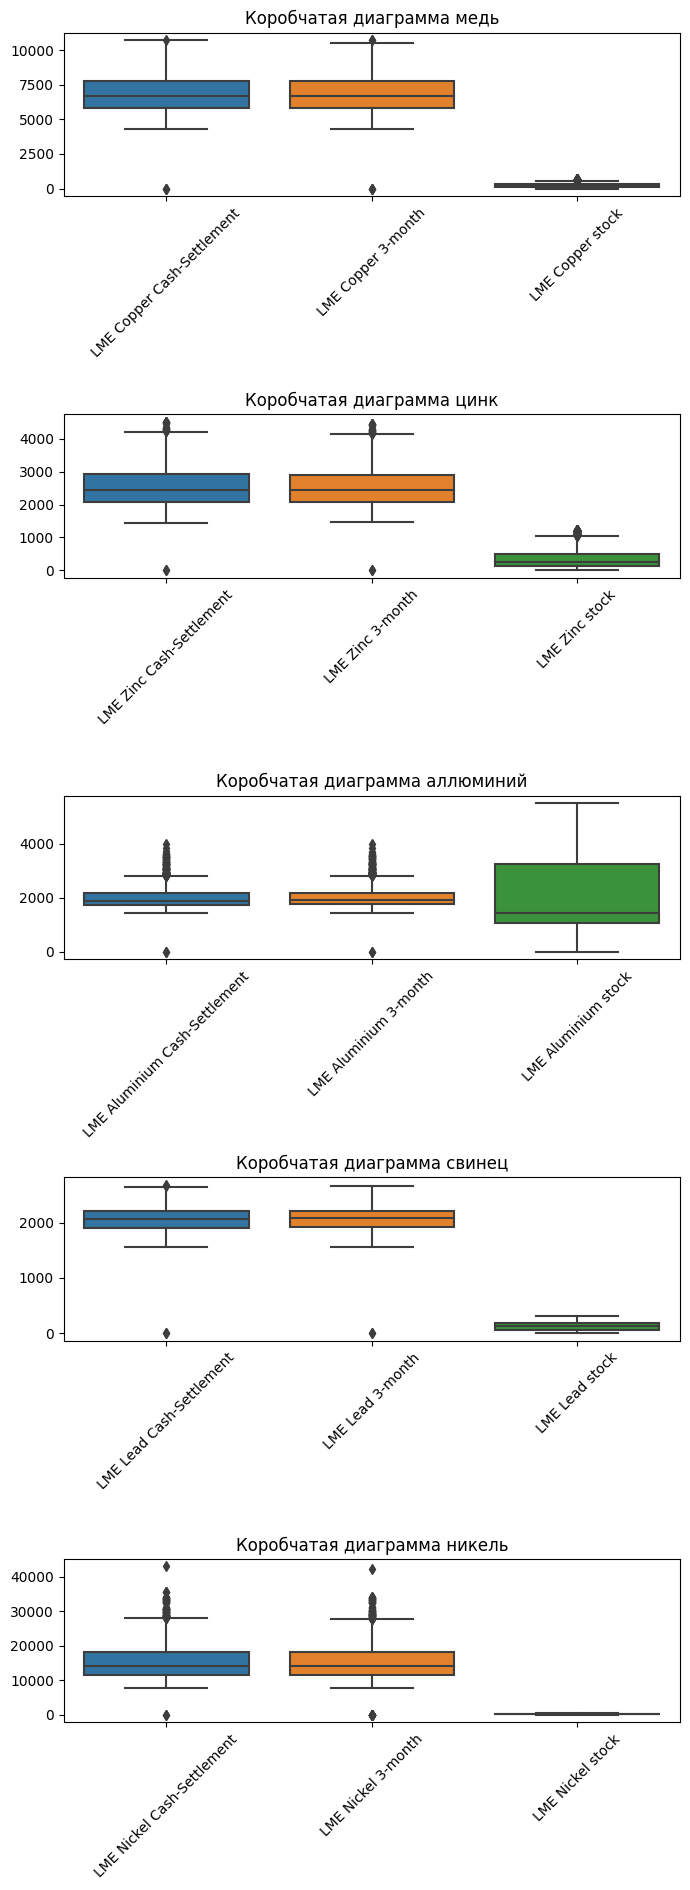

In [266]:
# В данном случае понятие выброса отсуствует, т.к. датасет составлен из
# реальных финансовых данных, следовательно мы должны выявить аномалии,
# конкретно здесь это нулевые значения в изначальном, неинтрерполированном
# датасете.
fig, axes = plt.subplots(5, 1, figsize=(7, 19))

box_cu = sns.boxplot(data=data_cu, ax=axes[0])
box_zn = sns.boxplot(data=data_zn, ax=axes[1])
box_al = sns.boxplot(data=data_al, ax=axes[2])
box_pb = sns.boxplot(data=data_pb, ax=axes[3])
box_ni = sns.boxplot(data=data_ni, ax=axes[4])


box_cu.set_title('Коробчатая диаграмма медь')
box_cu.set_xticklabels(box_cu.get_xticklabels(), rotation=45)

box_zn.set_title('Коробчатая диаграмма цинк')
box_zn.set_xticklabels(box_zn.get_xticklabels(), rotation=45)

box_al.set_title('Коробчатая диаграмма аллюминий')
box_al.set_xticklabels(box_al.get_xticklabels(), rotation=45)

box_pb.set_title('Коробчатая диаграмма свинец')
box_pb.set_xticklabels(box_pb.get_xticklabels(), rotation=45)

box_ni.set_title('Коробчатая диаграмма никель')
box_ni.set_xticklabels(box_ni.get_xticklabels(), rotation=45)

plt.tight_layout()

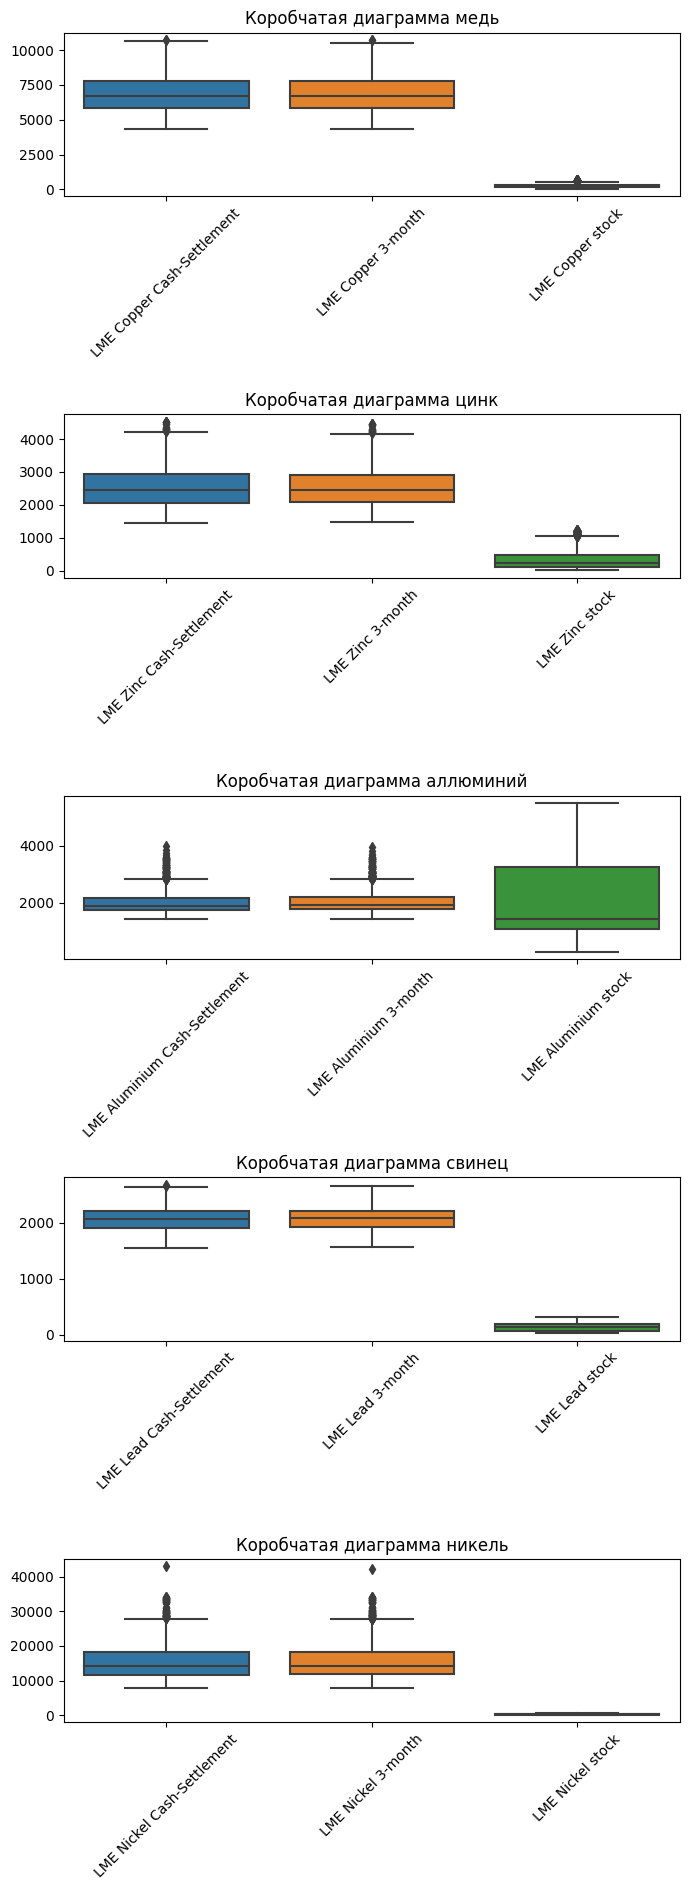

In [267]:
# Мы видим наличие нулевых значений
# Удаление ошибки
data_cu.replace(0, np.nan, inplace=True)
data_cu.dropna(inplace=True, axis=0)

data_zn.replace(0, np.nan, inplace=True)
data_zn.dropna(inplace=True, axis=0)

data_al.replace(0, np.nan, inplace=True)
data_al.dropna(inplace=True, axis=0)

data_pb.replace(0, np.nan, inplace=True)
data_pb.dropna(inplace=True, axis=0)

data_ni.replace(0, np.nan, inplace=True)
data_ni.dropna(inplace=True, axis=0)



# Убедимся в отсутвие пропусков
fig, axes = plt.subplots(5, 1, figsize=(7, 19))

box_cu = sns.boxplot(data=data_cu, ax=axes[0])
box_zn = sns.boxplot(data=data_zn, ax=axes[1])
box_al = sns.boxplot(data=data_al, ax=axes[2])
box_pb = sns.boxplot(data=data_pb, ax=axes[3])
box_ni = sns.boxplot(data=data_ni, ax=axes[4])


box_cu.set_title('Коробчатая диаграмма медь')
box_cu.set_xticklabels(box_cu.get_xticklabels(), rotation=45)

box_zn.set_title('Коробчатая диаграмма цинк')
box_zn.set_xticklabels(box_zn.get_xticklabels(), rotation=45)

box_al.set_title('Коробчатая диаграмма аллюминий')
box_al.set_xticklabels(box_al.get_xticklabels(), rotation=45)

box_pb.set_title('Коробчатая диаграмма свинец')
box_pb.set_xticklabels(box_pb.get_xticklabels(), rotation=45)

box_ni.set_title('Коробчатая диаграмма никель')
box_ni.set_xticklabels(box_ni.get_xticklabels(), rotation=45)

plt.tight_layout()

In [268]:
# Произведем интерполяцию
data_cu = data_cu.resample('d').interpolate(method='linear')
data_cu.reset_index(inplace=True)

data_zn = data_zn.resample('d').interpolate(method='linear')
data_zn.reset_index(inplace=True)

data_al = data_al.resample('d').interpolate(method='linear')
data_al.reset_index(inplace=True)

data_pb = data_pb.resample('d').interpolate(method='linear')
data_pb.reset_index(inplace=True)

data_ni = data_ni.resample('d').interpolate(method='linear')
data_ni.reset_index(inplace=True)

In [269]:
display(data_cu.head(), data_zn.head(), data_al.head(), data_pb.head(), data_ni.head())

,date,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
0,2013-01-02,8085.000000,8112.000000,320.500
1,2013-01-03,8140.500000,8166.000000,320.000
2,2013-01-04,8026.000000,8060.000000,320.225
3,2013-01-05,8015.833333,8050.833333,319.950
4,2013-01-06,8005.666667,8041.666667,319.675


,date,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
0,2013-01-02,2087.000000,2118.000000,1220.725000
1,2013-01-03,2092.000000,2127.000000,1218.050000
2,2013-01-04,2023.500000,2054.000000,1215.325000
3,2013-01-05,2010.666667,2042.166667,1214.408333
4,2013-01-06,1997.833333,2030.333333,1213.491667


,date,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
0,2013-01-02,2093.5,2128.0,5210.350000
1,2013-01-03,2108.5,2145.5,5212.500000
2,2013-01-04,2056.0,2089.0,5217.250000
3,2013-01-05,2039.0,2073.0,5216.008333
4,2013-01-06,2022.0,2057.0,5214.766667


,date,LME Lead Cash-Settlement,LME Lead 3-month,LME Lead stock
0,2013-01-02,2385.0,2390.500000,317.700000
1,2013-01-03,2412.5,2419.500000,314.550000
2,2013-01-04,2343.0,2355.000000,312.625000
3,2013-01-05,2325.0,2335.166667,311.641667
4,2013-01-06,2307.0,2315.333333,310.658333


,date,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
0,2013-01-02,17425.000000,17500.000000,141.690
1,2013-01-03,17540.000000,17595.000000,141.708
2,2013-01-04,17325.000000,17405.000000,141.672
3,2013-01-05,17288.333333,17366.666667,141.864
4,2013-01-06,17251.666667,17328.333333,142.056


In [270]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data_cu['date'].iloc[-1])
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

In [271]:
# Объединим таблицы
data_cu = pd.concat([data_cu, data_prognosis])
data_zn = pd.concat([data_zn, data_prognosis])
data_al = pd.concat([data_al, data_prognosis])
data_pb = pd.concat([data_pb, data_prognosis])
data_ni = pd.concat([data_ni, data_prognosis])


In [272]:
# Отcортируем и вернем индексы
data_cu = data_cu.sort_values(by='date')
data_zn = data_zn.sort_values(by='date')
data_al = data_al.sort_values(by='date')
data_pb = data_pb.sort_values(by='date')
data_ni = data_ni.sort_values(by='date')


In [273]:
# Произведем сдвиг LME 3-month, представляющим своего рода фьючерс
# (точнее представляет цену для операций сроком на 3 месяца. 
#  Это означает, что цена отражает стоимость на рынке с учетом сроковых контрактов на 3 месяца.)
data_cu['LME Copper 3-month'] = data_cu['LME Copper 3-month'].shift(90)
data_zn['LME Zinc 3-month'] = data_zn['LME Zinc 3-month'].shift(90)
data_al['LME Aluminium 3-month'] = data_al['LME Aluminium 3-month'].shift(90)
data_pb['LME Lead 3-month'] = data_pb['LME Lead 3-month'].shift(90)
data_ni['LME Nickel 3-month'] = data_ni['LME Nickel 3-month'].shift(90)

# Обрежем 13 год, т.к. мы получили наши фьючерсы
data_cu = data_cu[data_cu['date'].dt.year != 2013]
data_zn = data_zn[data_zn['date'].dt.year != 2013]
data_al = data_al[data_al['date'].dt.year != 2013]
data_pb = data_pb[data_pb['date'].dt.year != 2013]
data_ni = data_ni[data_ni['date'].dt.year != 2013]

display(data_cu.head(), data_cu.tail(),
        data_zn.head(), data_zn.tail(), 
        data_al.head(), data_al.tail(), 
        data_pb.head(), data_pb.tail(), 
        data_ni.head(), data_ni.tail())

,date,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
364,2014-01-01,7417.000000,7245.5,365.700000
365,2014-01-02,7439.500000,7182.0,365.700000
366,2014-01-03,7335.500000,7189.5,359.075000
367,2014-01-04,7328.166667,7197.0,358.091667
368,2014-01-05,7320.833333,7204.5,357.108333


,date,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
85,2023-12-08,NaN,8320.666667,NaN
86,2023-12-09,NaN,8360.000000,NaN
87,2023-12-10,NaN,8365.000000,NaN
88,2023-12-11,NaN,8371.500000,NaN
89,2023-12-12,NaN,8465.000000,NaN


,date,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
364,2014-01-01,2083.750000,1877.500000,931.175000
365,2014-01-02,2082.000000,1869.000000,931.175000
366,2014-01-03,2044.500000,1869.333333,927.225000
367,2014-01-04,2038.166667,1869.666667,925.766667
368,2014-01-05,2031.833333,1870.000000,924.308333


,date,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
85,2023-12-08,NaN,2453.333333,NaN
86,2023-12-09,NaN,2465.000000,NaN
87,2023-12-10,NaN,2500.000000,NaN
88,2023-12-11,NaN,2484.000000,NaN
89,2023-12-12,NaN,2575.000000,NaN


,date,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
364,2014-01-01,1760.0,1832.5,5451.80
365,2014-01-02,1755.5,1831.5,5451.80
366,2014-01-03,1738.5,1833.5,5459.75
367,2014-01-04,1731.5,1835.5,5458.30
368,2014-01-05,1724.5,1837.5,5456.85


,date,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
85,2023-12-08,NaN,2190.333333,NaN
86,2023-12-09,NaN,2195.000000,NaN
87,2023-12-10,NaN,2199.000000,NaN
88,2023-12-11,NaN,2197.000000,NaN
89,2023-12-12,NaN,2235.000000,NaN


,date,LME Lead Cash-Settlement,LME Lead 3-month,LME Lead stock
364,2014-01-01,2209.000000,2073.000000,213.950000
365,2014-01-02,2212.000000,2057.000000,213.950000
366,2014-01-03,2168.000000,2055.833333,215.200000
367,2014-01-04,2157.333333,2054.666667,215.133333
368,2014-01-05,2146.666667,2053.500000,215.066667


,date,LME Lead Cash-Settlement,LME Lead 3-month,LME Lead stock
85,2023-12-08,NaN,2236.333333,NaN
86,2023-12-09,NaN,2245.000000,NaN
87,2023-12-10,NaN,2233.000000,NaN
88,2023-12-11,NaN,2210.000000,NaN
89,2023-12-12,NaN,2230.000000,NaN


,date,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
364,2014-01-01,13937.5,13700.000000,261.468
365,2014-01-02,13905.0,13640.000000,261.468
366,2014-01-03,13870.0,13726.666667,260.706
367,2014-01-04,13770.0,13813.333333,260.758
368,2014-01-05,13670.0,13900.000000,260.810


,date,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
85,2023-12-08,NaN,20215.0,NaN
86,2023-12-09,NaN,20260.0,NaN
87,2023-12-10,NaN,20025.0,NaN
88,2023-12-11,NaN,19750.0,NaN
89,2023-12-12,NaN,20430.0,NaN


In [275]:
working_data_cu

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2014-01-01,7417.000000,7245.5,365.700000
2014-01-02,7439.500000,7182.0,365.700000
2014-01-03,7335.500000,7189.5,359.075000
2014-01-04,7328.166667,7197.0,358.091667
2014-01-05,7320.833333,7204.5,357.108333
...,...,...,...
2023-09-10,8296.666667,8320.0,134.391667
2023-09-11,8332.500000,8444.0,134.525000
2023-09-12,8337.500000,8466.5,135.650000


In [283]:
# Выделим ту часть датафрейма, которую мы будем в дальнейшем прогнозировать за счет информации по фьючерсам и спрогнозированным запасам
data_target_cu = data_cu[data_cu['LME Copper stock'].isna()]
data_target_zn = data_zn[data_zn['LME Zinc 3-month'].isna()]
data_target_al = data_al[data_al['LME Aluminium 3-month'].isna()]
data_target_pb = data_pb[data_pb['LME Lead 3-month'].isna()]
data_target_ni = data_ni[data_ni['LME Nickel 3-month'].isna()]

data_target_cu.set_index('date', inplace=True)
data_target_zn.set_index('date', inplace=True)
data_target_al.set_index('date', inplace=True)
data_target_pb.set_index('date', inplace=True)
data_target_ni.set_index('date', inplace=True)


# А так же ту часть, которую будем использовать для работы
working_data_cu = data_cu[~data_cu['LME Copper stock'].isna()]
working_data_cu.set_index('date', inplace=True)

working_data_zn = data_zn[~data_zn['LME Zinc stock'].isna()]
working_data_zn.set_index('date', inplace=True)

working_data_al = data_al[~data_al['LME Aluminium stock'].isna()]
working_data_al.set_index('date', inplace=True)

working_data_pb = data_pb[~data_pb['LME Lead stock'].isna()]
working_data_pb.set_index('date', inplace=True)

working_data_ni = data_ni[~data_ni['LME Nickel stock'].isna()]
working_data_ni.set_index('date', inplace=True)

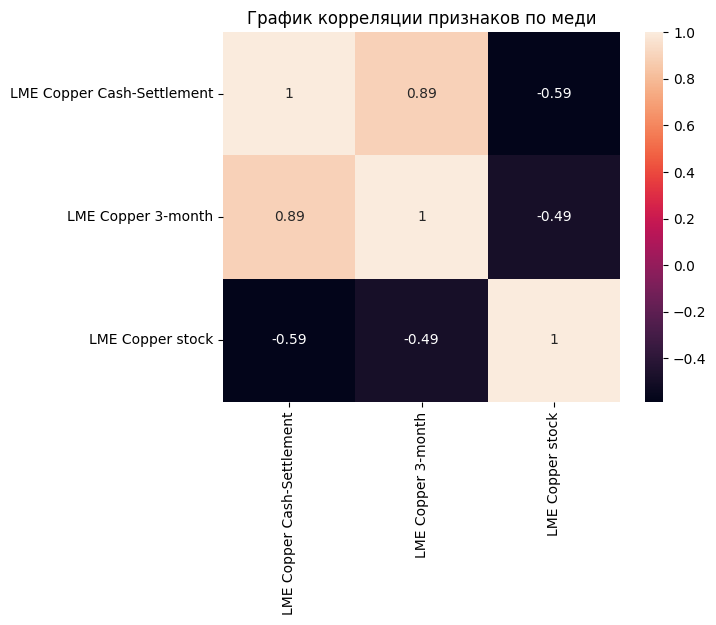

In [288]:
# Визуализируем корреляцию в полученных таблицах
corr_graph_cu = sns.heatmap(data=working_data_cu.corr(), annot=True)
corr_graph_cu.set_title('График корреляции признаков по меди');

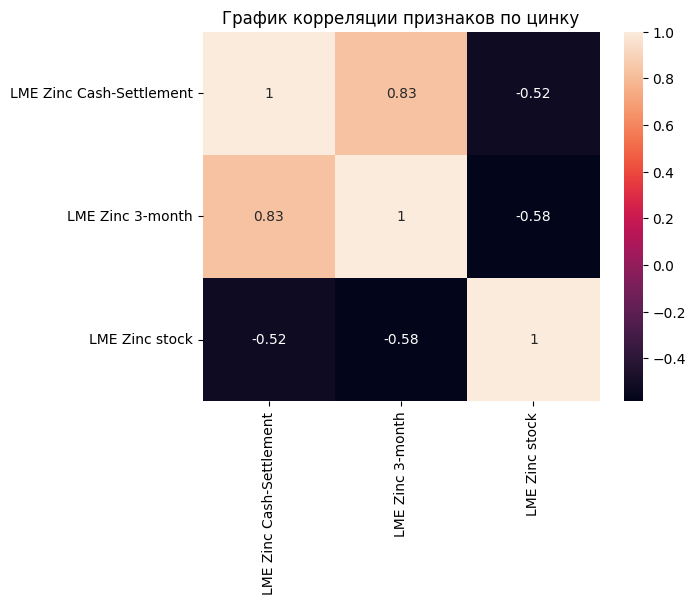

In [289]:
corr_graph_zn = sns.heatmap(data=working_data_zn.corr(), annot=True)
corr_graph_zn.set_title('График корреляции признаков по цинку');

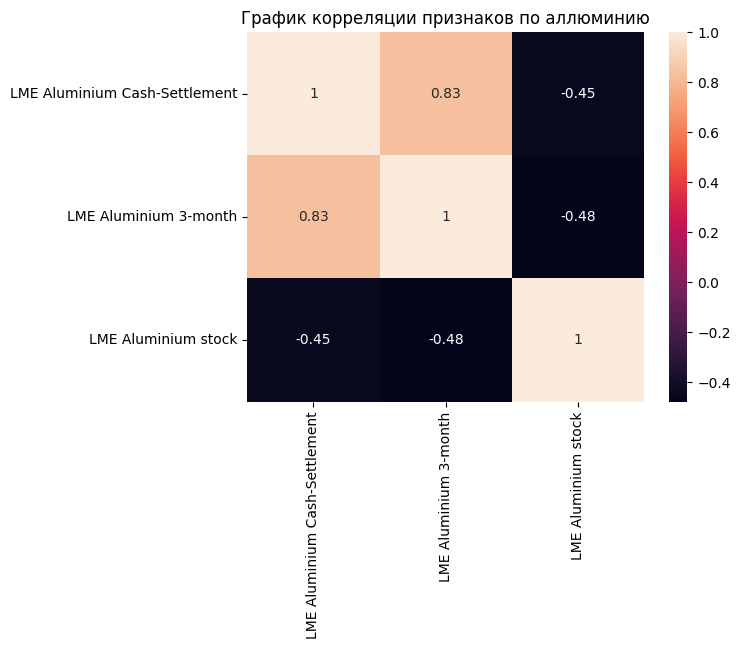

In [290]:
corr_graph_al = sns.heatmap(data=working_data_al.corr(), annot=True)
corr_graph_al.set_title('График корреляции признаков по алюминию');

Text(0.5, 1.0, 'График корреляции признаков по свинцу')

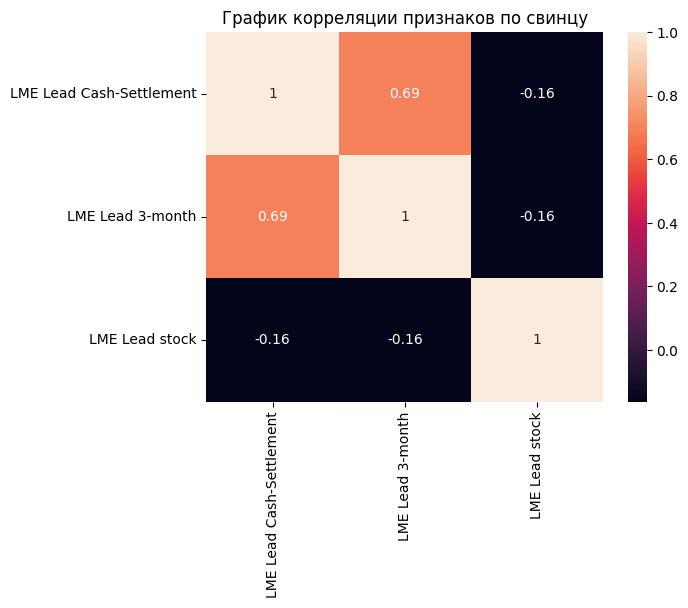

In [291]:
corr_graph_pb = sns.heatmap(data=working_data_pb.corr(), annot=True)
corr_graph_pb.set_title('График корреляции признаков по свинцу')

Text(0.5, 1.0, 'График корреляции признаков по никелю')

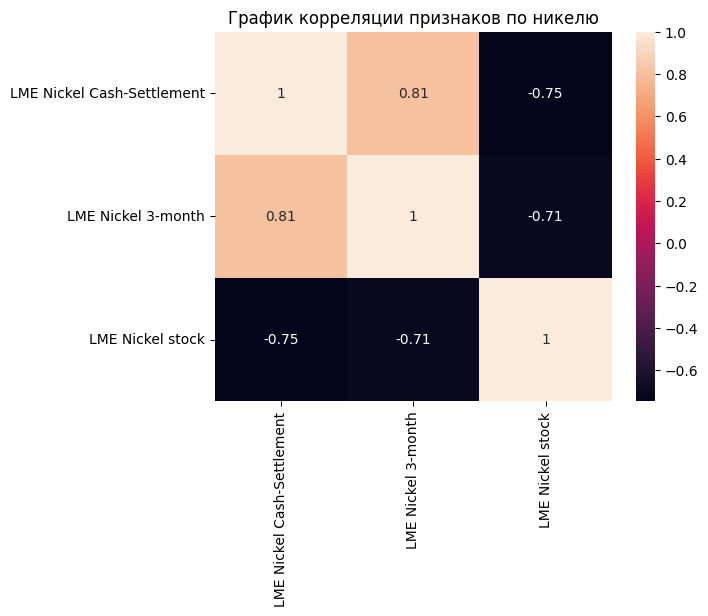

In [292]:
corr_graph_ni = sns.heatmap(data=working_data_ni.corr(), annot=True)
corr_graph_ni.set_title('График корреляции признаков по никелю')

#### Наша задача сформировать прогноз на 90 дней вперед, исходя из предположения о том, что сдвинутые на 3 месяца данные по фьючерсам (со сроком исполнения в 3 месяца, потому такой сдвиг) имеют высокую корреляцию с показателем целевой переменной спотовой цены.
#### Так же нужно отметить достаточный уровень обратной корреляции между спотом и запасами, что логично исходя из закона о спросе и предложении, при этом влияние запасов на фьючерсы не несет характер мультиколлинеарности.
#### Хотел бы отметить, что был эксперимент с внедрением данных из разных источников, но с целевой переменной корреляция была слишком слаба, при этом сильно усложнялся этап парсинга и последующей автоматизации скрипта, который в планах перевести на микросервис, т.е. затраты и потери от внедрения доп информации был слишком дорог для реального применения.

----

## Часть 1.

### Прогнозирование временного ряда запасов (LME stock) и спотовой цены (LME Cash-Settlement)

#### Первичный анализ данных.

In [302]:
# Будем прогнозировать временной ряд LME Copper stock и 
# LME Copper Cash-Settlement, т.к. данная переменная имеет непосредственную связь с фактором времени
# Для начала проведем декомпозицию временных рядов

stock_cu = working_data_cu.iloc[:,2]
spot_cu = working_data_cu.iloc[:,0]

stock_zn = working_data_zn.iloc[:,2]
spot_zn = working_data_zn.iloc[:,0]

stock_al = working_data_al.iloc[:,2]
spot_al = working_data_al.iloc[:,0]

stock_pb = working_data_pb.iloc[:,2]
spot_pb = working_data_pb.iloc[:,0]

stock_ni = working_data_ni.iloc[:,2]
spot_ni = working_data_ni.iloc[:,0]

decompose_stock_cu = seasonal_decompose(stock_cu)
decompose_spot_cu = seasonal_decompose(spot_cu)

decompose_stock_zn = seasonal_decompose(stock_zn)
decompose_spot_zn = seasonal_decompose(spot_zn)

decompose_stock_al = seasonal_decompose(stock_al)
decompose_spot_al = seasonal_decompose(spot_al)

decompose_stock_pb = seasonal_decompose(stock_pb)
decompose_spot_pb = seasonal_decompose(spot_pb)

decompose_stock_ni = seasonal_decompose(stock_ni)
decompose_spot_ni = seasonal_decompose(spot_ni)


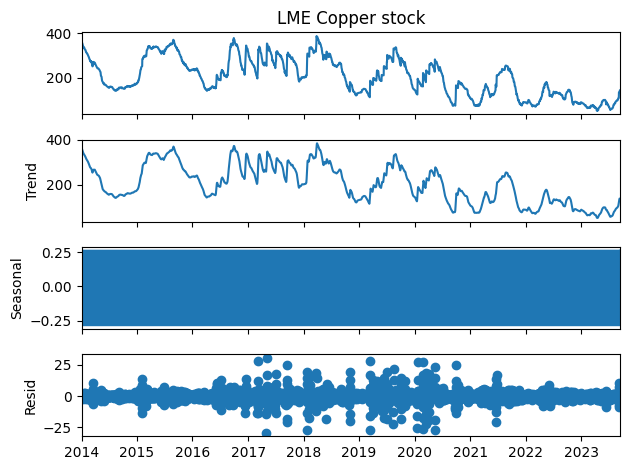

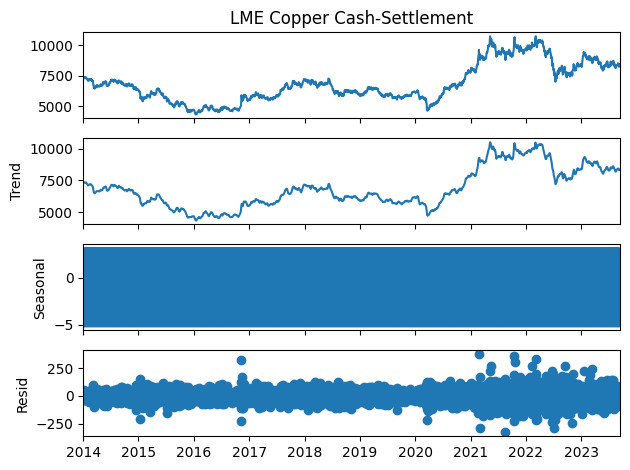

In [303]:
# Разложение для меди
decompose_stock_cu.plot()
decompose_spot_cu.plot()
plt.show()

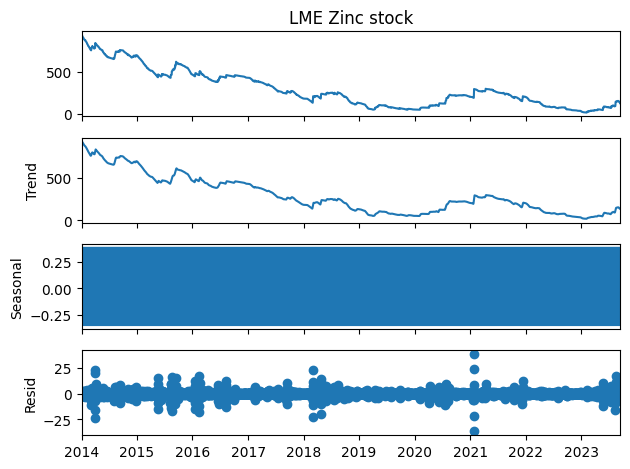

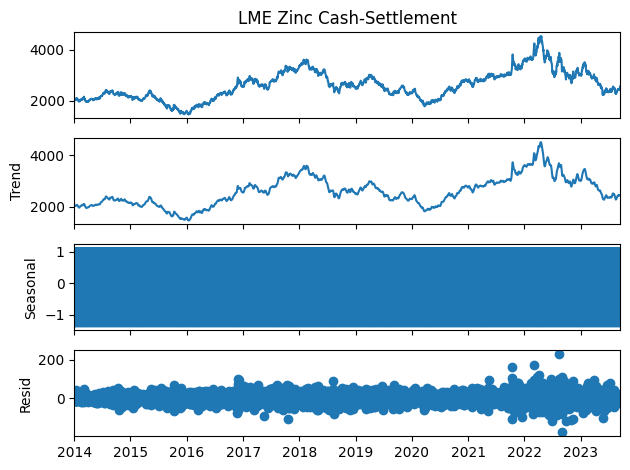

In [304]:
# Разложение для цинка
decompose_stock_zn.plot()
decompose_spot_zn.plot()
plt.show()

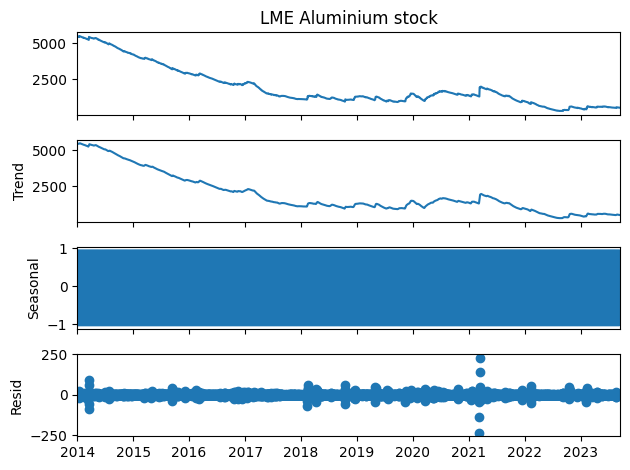

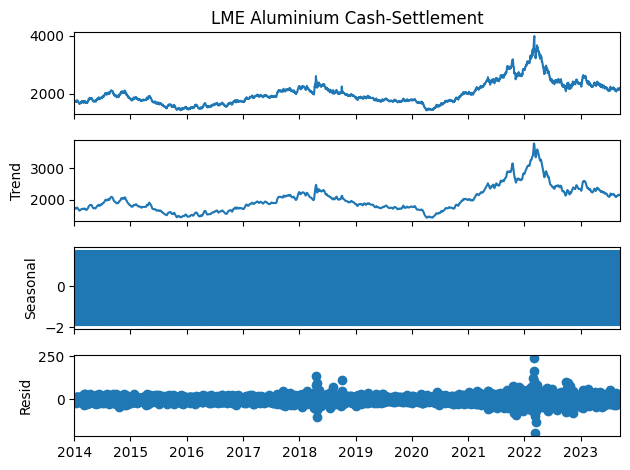

In [305]:
# Разложение для алюминия
decompose_stock_al.plot()
decompose_spot_al.plot()
plt.show()

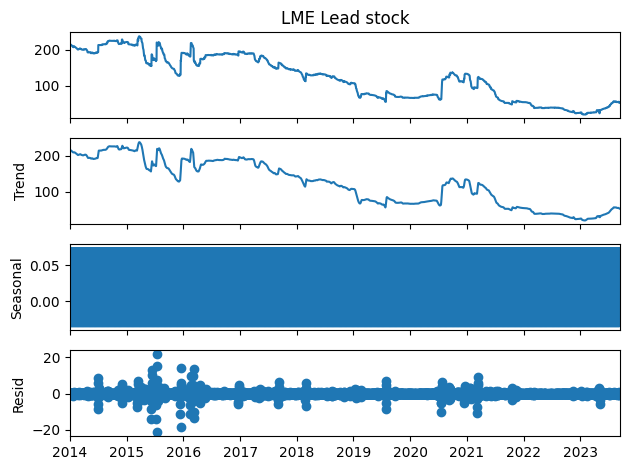

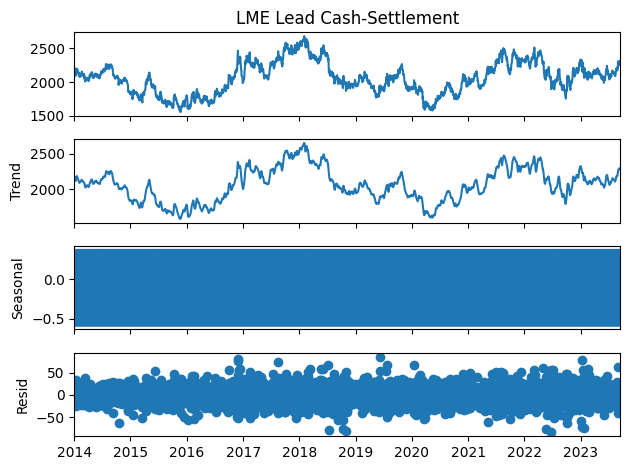

In [306]:
# Разложение для свинца
decompose_stock_pb.plot()
decompose_spot_pb.plot()
plt.show()

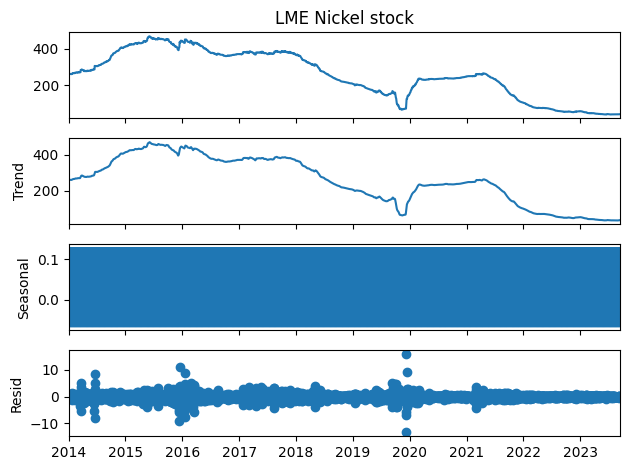

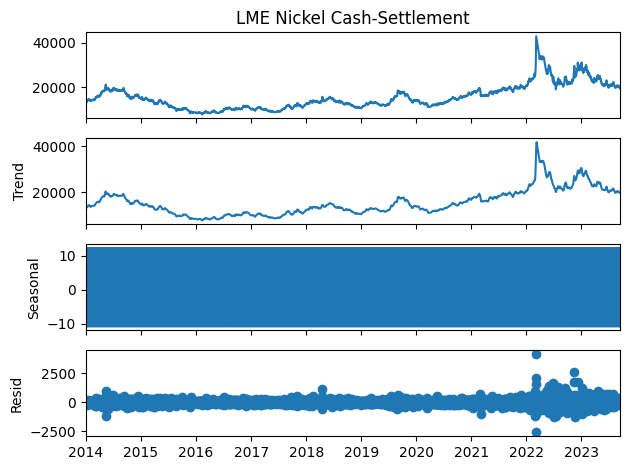

In [307]:
# Разложение для никеля
decompose_stock_ni.plot()
decompose_spot_ni.plot()
plt.show()

> Вывод: Мы можем наблюдать большие остатки при сезонном разложении спотовых цен, вероятной причиной этого может быть влияние экзогенных факторов, от глобальных циклов экономики и геополитических сдвигов, до возможных спекулятивных манипуляций, уже на данном этапе можно сказать, что прогнозирование цены влоб, через ARIMA будет не самой разумной идеей. Возможно сработал бы подход с анализом и прогнозом остатков параллельно с основной компонентой.

> С запасами картина более радужная, физические запасы металла на бирже величина менее волатильная, что вселяет надежду в возможность формирования прогноза данной величины и использования ее как фактора в другом типе мл, но об этом позже.


---

Единичных корней нет, ряд стационарен
{'p_value': 0.026224153560120336, 'crit_value (5%)': -2.8623577320702904}
Единичных корней нет, ряд стационарен
{'p_value': 0.646672040653687, 'crit_value (5%)': -2.8623565769276325}


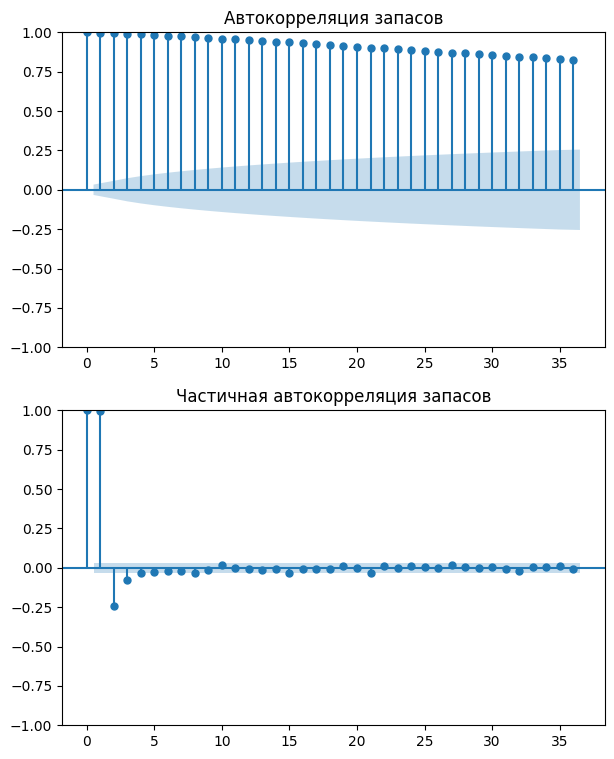

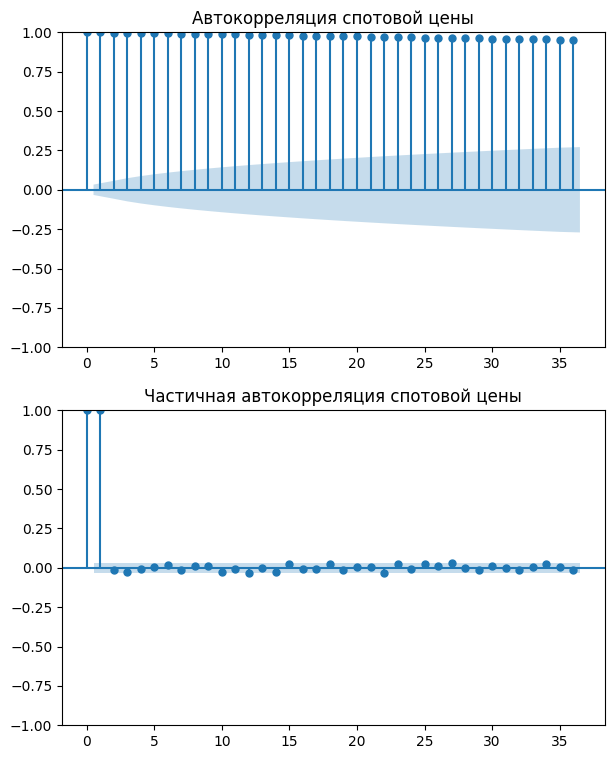

In [315]:
# Проведем тест стационарности меди выведем графики acf и pacf
stationary_test(stock_cu, name='запасов')
stationary_test(spot_cu, name='спотовой цены')

Единичных корней нет, ряд стационарен
{'p_value': 0.10830092780571615, 'crit_value (5%)': -2.8623628537670136}
Единичных корней нет, ряд стационарен
{'p_value': 0.21979366564849412, 'crit_value (5%)': -2.8623565769276325}


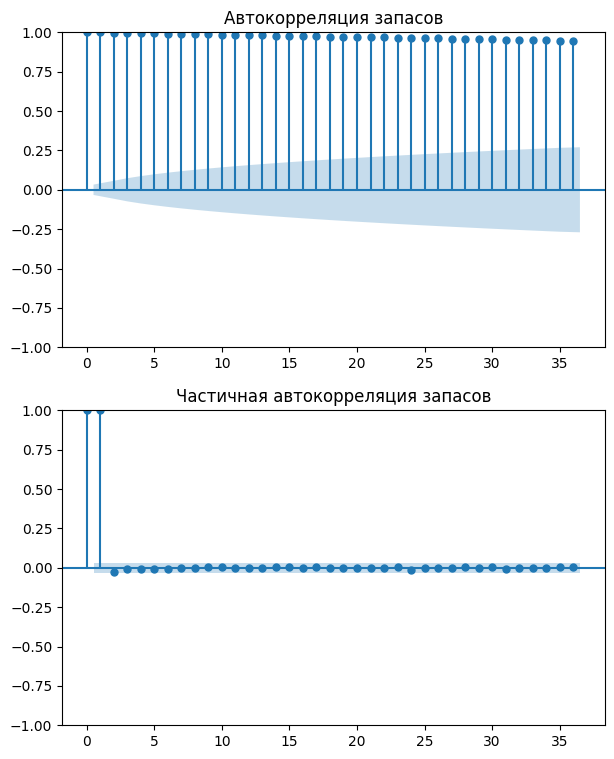

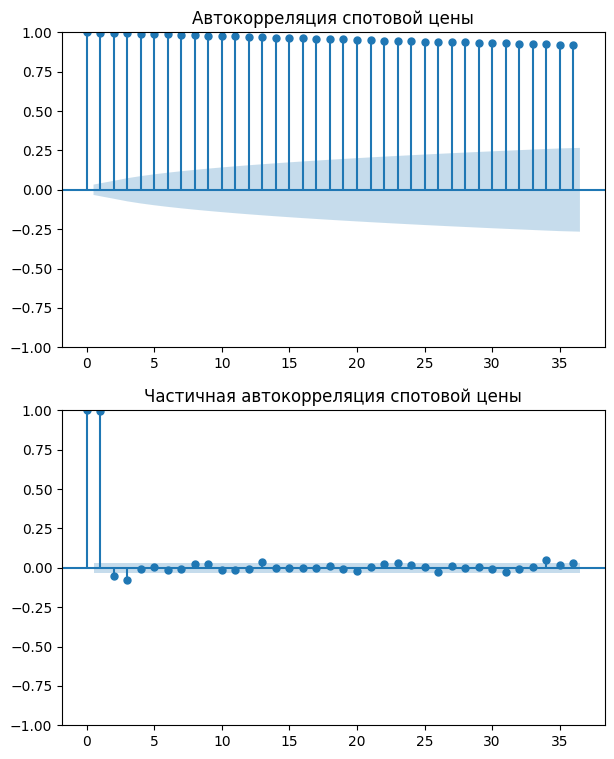

In [310]:
# Проведем тест стационарности цинка выведем графики acf и pacf
stationary_test(stock_zn, name='запасов')
stationary_test(spot_zn, name='спотовой цены')

Единичных корней нет, ряд стационарен
{'p_value': 0.009468791147632561, 'crit_value (5%)': -2.8623577320702904}
Единичных корней нет, ряд стационарен
{'p_value': 0.42890479680358384, 'crit_value (5%)': -2.8623588904857473}


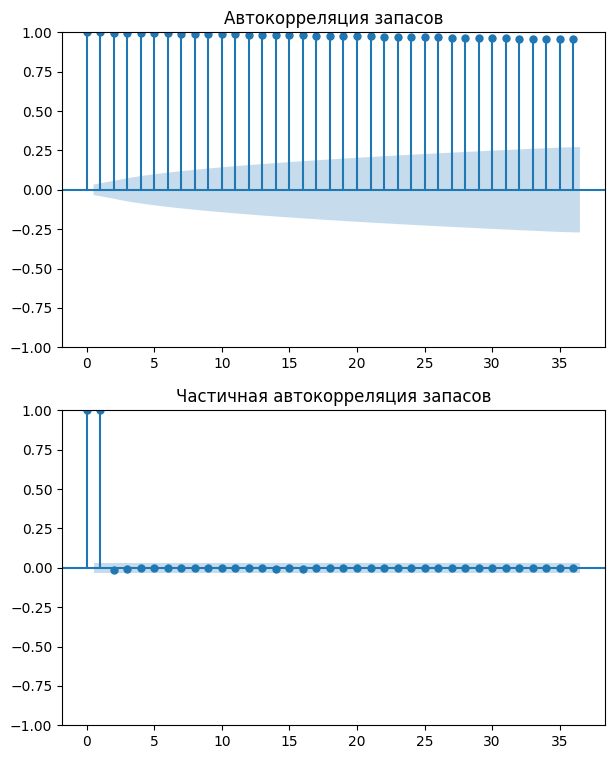

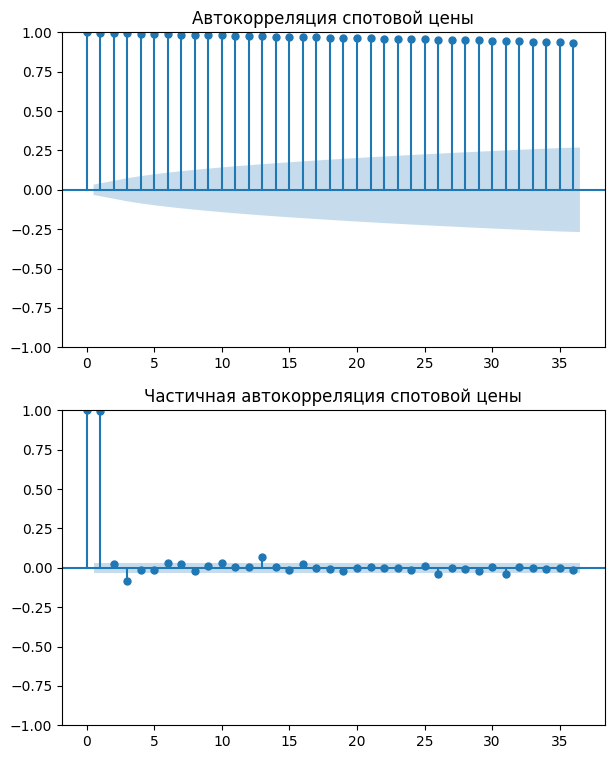

In [311]:
# Проведем тест стационарности алюминия выведем графики acf и pacf
stationary_test(stock_al, name='запасов')
stationary_test(spot_al, name='спотовой цены')

Единичных корней нет, ряд стационарен
{'p_value': 0.5528044606516399, 'crit_value (5%)': -2.862357038592848}
Единичных корней нет, ряд стационарен
{'p_value': 0.0311732797698976, 'crit_value (5%)': -2.862356807695006}


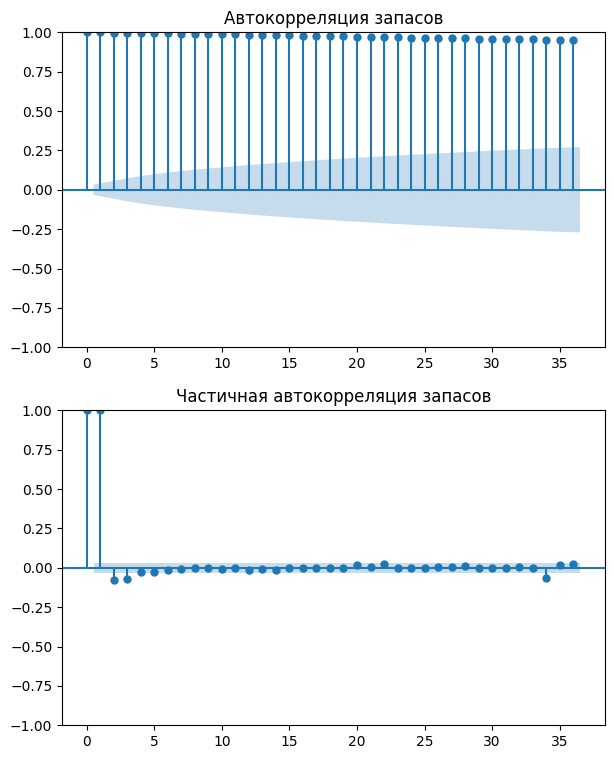

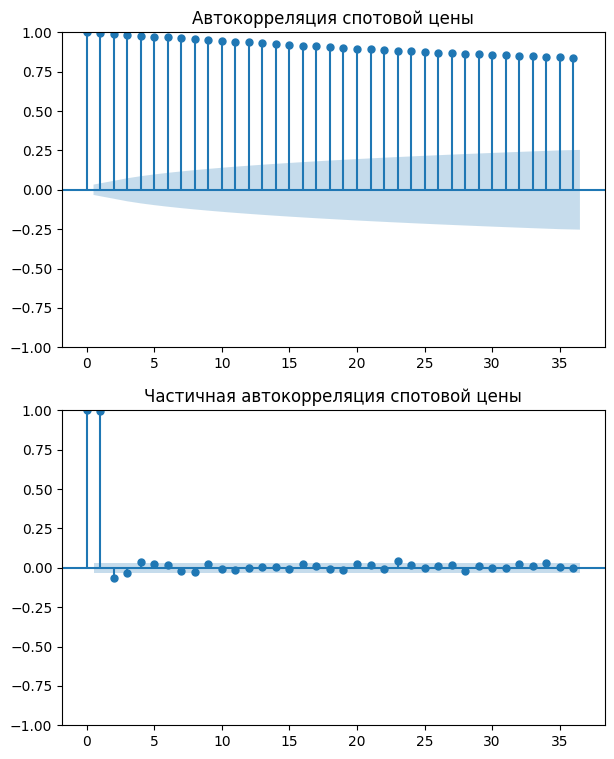

In [312]:
# Проведем тест стационарности свинца выведем графики acf и pacf
stationary_test(stock_pb, name='запасов')
stationary_test(spot_pb, name='спотовой цены')

Единичных корней нет, ряд стационарен
{'p_value': 0.9249791355365903, 'crit_value (5%)': -2.8623628537670136}
Единичных корней нет, ряд стационарен
{'p_value': 0.44075528821260146, 'crit_value (5%)': -2.8623623855085953}


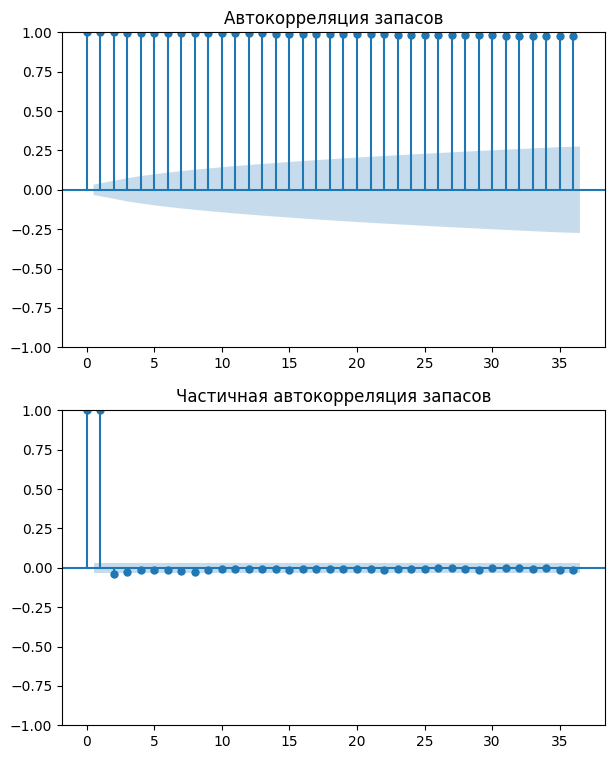

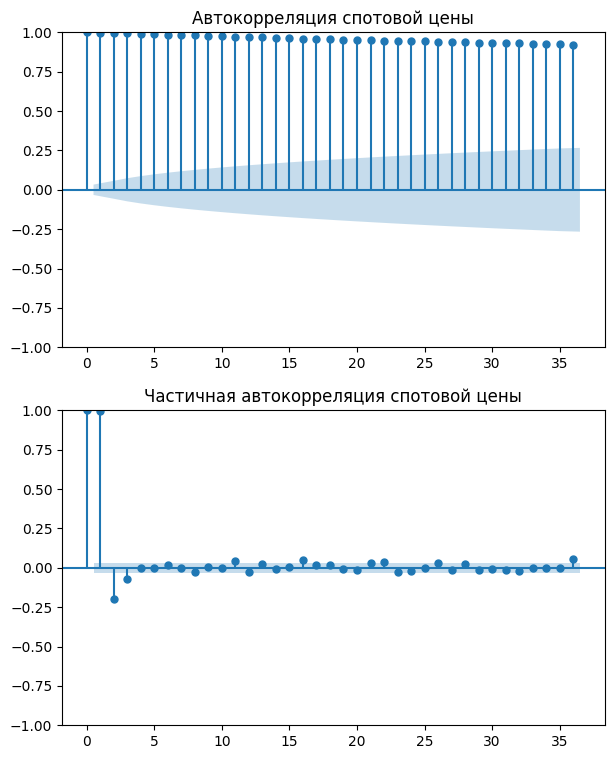

In [313]:
# Проведем тест стационарности никеля выведем графики acf и pacf
stationary_test(stock_ni, name='запасов')
stationary_test(spot_ni, name='спотовой цены')

> Вывод: Все ряды стационарны, что не может не радовать, диференцирование не требуется.

> Исходя из представленных выше графиков частичной автокорреляции присвоим переменным p соответсвующие значения, сообразно рассмотренным металлам

In [316]:
p_stock_cu = 2
p_spot_cu = 1

p_stock_zn = 1
p_spot_zn = 1

p_stock_al = 1
p_spot_al = 1

p_stock_pb = 1
p_spot_pb = 1

p_stock_ni = 1
p_spot_ni = 2

---

#### Baseline модель для данного этапа исследования.

##### Здесь мы убьем двух зайцев и сразу спрогнозируем и спот и запасы через базовую авторегрессионную модель, далее мы так же будем прогнозировать спок прайс, хоть изначально и планировалось сформировать для него конечный прогноз через random-forest regressor через фиты фьючерса и запасов, но может статься что по итогу выиграет простая стратегия.

In [70]:
train_stock = stock[:-len(data_target)]
test_stock = stock[-len(data_target):]

train_spot = spot[:-len(data_target)]
test_spot = spot[-len(data_target):]

In [71]:
ar_model_stock = AutoReg(train_stock, lags=p_stock).fit()
ar_model_spot = AutoReg(train_spot, lags=p_spot).fit()

In [72]:
pred_ar_stock = ar_model_stock.predict(start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
pred_ar_spot = ar_model_spot.predict(start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

In [143]:
# Оценим baseline по rmse, mae и mape
bl_ar_stock = metrics_calculation(test_stock, pred_ar_stock, name='baseline AR')
print('\n')
log_stock_df = pd.concat([log_stock_df, bl_ar_stock])
log_stock_df.drop_duplicates(inplace=True)

with pd.ExcelWriter('./data/log_stock.xlsx') as writer:
    log_stock_df.to_excel(writer, sheet_name='LME_stock_logs')


# Занесем результаты baseline AR model в таблицу результатов
bl_ar_spot = metrics_calculation(
    test_spot, pred_ar_spot, name='baseline AR')
log_spot_df = pd.concat([log_spot_df, bl_ar_spot])
log_spot_df.drop_duplicates(inplace=True)

with pd.ExcelWriter('./data/log_spot.xlsx') as writer:
    log_spot_df.to_excel(writer, sheet_name='LME_spot_logs')

RMSE для baseline AR: 30.419
MAE для baseline AR: 27.652
MAPE для sbaseline AR: 38.5%


RMSE для baseline AR: 169.197
MAE для baseline AR: 138.461
MAPE для sbaseline AR: 1.7000000000000002%


> Вывод: Весьма неожиданный результат для базовой модели спотовой цены (для нас это таргет который мы и планируем спрогнозировать), с учетом того, что в бенчмарках консалтинговых и аналитических агенств допускается разброс в 300 долларов, мы получили значительно большую точность при больших остатках на декомпозиции и околонулевой обработке данных. Данной точности вполне хватило бы для легковестного бенчмарка для использования в работе

> Результат на запасах при этом показал вполне предсказуемый для baseline модели.

---